# Document Classification and Information Extraction Technical Test

## Introduction

This technical test evaluates your skills in building a document processing system that can:

1. **Classify different types of document images** (ID cards, driver's licenses, invoices)
2. **Extract key information** from each document type

You're free to use any approach or OCR method you prefer, but your solution should be well-documented and explained.

## Setup

First, let's set up our environment and import necessary libraries:

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from typing import Dict, List, Tuple, Any

# Set up matplotlib for inline display
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)

# Define document types
DOCUMENT_TYPES = ['drivers_license', 'invoice', 'passport']

# Define the document structure for field extraction
DOCUMENT_FIELDS = {
    'id_card': ['full_name', 'id_number', 'date_of_birth'],
    # 'drivers_license': ['full_name', 'license_number', 'expiration_date'],
    "drivers_license": [
        "first_name", 
        "last_name", 
        "date_of_expiry", 
        "license_number",
    ],
    "passport": [
      "last_name",
      "first_name",
      "expire_date",
      "place_of_birth",
      "card_num",
    ],
    'invoice': [
        'buyer', 
        'due_date',
        'seller_address', 
        'seller_email',
        'total',
    ]}

In [3]:
import json
import pandas as pd
import srsly

In [ ]:
text_columns = [column for column in df.columns if "text" in column ]

df[text_columns].rename(columns={column: column.split(".")[0]  for column in text_columns}).columns

## Task 1: Data Loading and Exploration

Your first task is to load and explore the document images dataset.

In [ ]:
def load_images(data_path: str) -> Tuple[List[np.ndarray], List[str]]:
    """
    Load images from the data directory.
    
    Args:
        data_path: Path to directory containing document images
        
    Returns:
        Tuple containing list of images and their corresponding labels
    """
    images = []
    labels = []
    
    # Define supported image extensions
    image_extensions = {'.png', '.jpg', '.jpeg'}
    
    for item in os.listdir(data_path):
        item_path = os.path.join(data_path, item)
        
        if not os.path.isdir(item_path):
            continue
            
        if item == 'labels':
            continue
            
        label = item
        
        # Load images from this directory
        for file_name in os.listdir(item_path):
            file_path = os.path.join(item_path, file_name)
            
            _, ext = os.path.splitext(file_name.lower())
            if ext in image_extensions:
                try:
                    image = cv2.imread(file_path)
                    
                    if image is not None:
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                        images.append(image)
                        labels.append(label)
                    else:
                        print(f"Warning: Could not load image {file_path}")
                        
                except Exception as e:
                    print(f"Error loading image {file_path}: {e}")
    
    print(f"Loaded {len(images)} images")
    print(f"Document types found: {set(labels)}")
    print(f"Images per type: {dict(zip(*np.unique(labels, return_counts=True)))}")
    
    return images, labels
    

In [6]:
# Test the load_images function
data_path = "../data"
images, labels = load_images(data_path)


Loaded 300 images
Document types found: {'invoice', 'passport', 'drivers_license'}
Images per type: {np.str_('drivers_license'): np.int64(100), np.str_('invoice'): np.int64(100), np.str_('passport'): np.int64(100)}


Now, visualize some examples to understand the dataset better:

In [7]:
import random

In [ ]:
# Complete implementation of visualize_examples function
def visualize_examples(images: List[np.ndarray], labels: List[str], num_examples: int = 2):
    """
    Visualize example images from each document type.
    
    Args:
        images: List of document images
        labels: List of document type labels
        num_examples: Number of examples to show for each type
    """
    
    # Get unique document types
    unique_labels = list(set(labels))
    unique_labels.sort()  
    
    # Calculate grid dimensions
    num_types = len(unique_labels)
    total_examples = num_types * num_examples
    
    # Create subplots
    fig, axes = plt.subplots(num_types, num_examples, figsize=(4 * num_examples, 3 * num_types))
    

    if num_types == 1:
        axes = axes.reshape(1, -1)
    if num_examples == 1:
        axes = axes.reshape(-1, 1)
    
    # For each document type
    for type_idx, doc_type in enumerate(unique_labels):
        type_indices = [i for i, label in enumerate(labels) if label == doc_type]
        
        # Randomly select examples (with replacement if needed)
        selected_indices = random.choices(type_indices, k=num_examples)
        
        # Display the selected examples
        for example_idx, img_idx in enumerate(selected_indices):
            ax = axes[type_idx, example_idx]
            
            # Display the image
            ax.imshow(images[img_idx])
            ax.set_title(f'{doc_type}\nExample {example_idx + 1}')
            ax.axis('off')  # Remove axes for cleaner look
    
    # Adjust layout to prevent overlapping
    plt.tight_layout()
    plt.show()
    
    # Print summary information
    print(f"Displayed {num_examples} examples from each of {num_types} document types:")
    # for doc_type in unique_labels:
    #     count = labels.count(doc_type)
    #     print(f"  - {doc_type}: {count} total images")


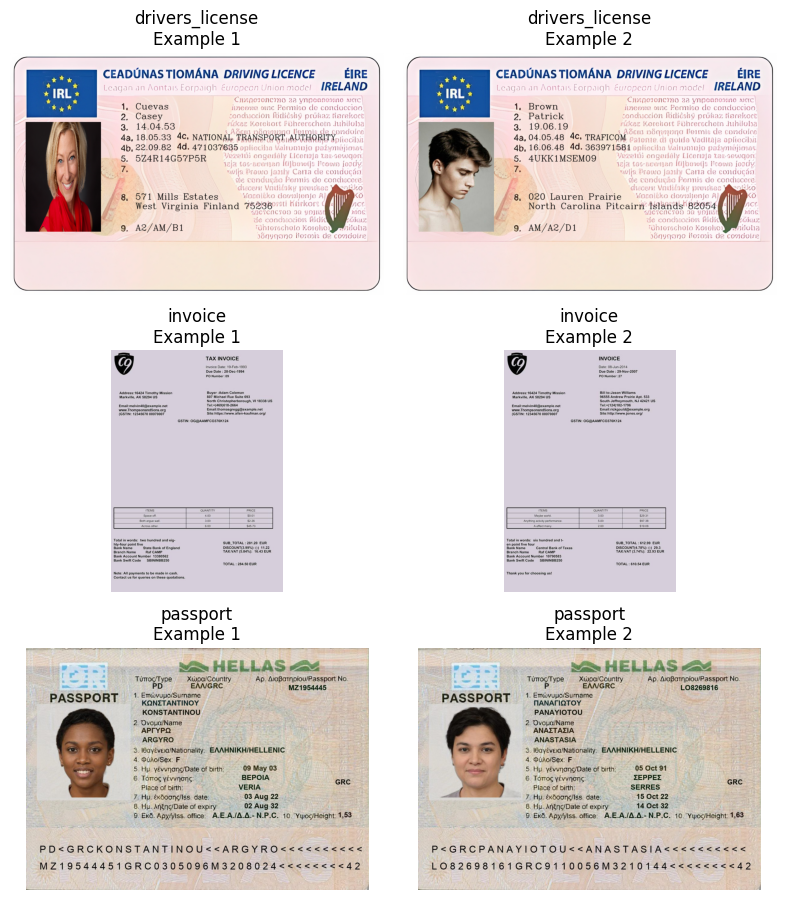

Displayed 2 examples from each of 3 document types:


In [19]:
# Test the visualize_examples function
visualize_examples(images, labels, num_examples=2)

## Task 2: Image Preprocessing

Next, implement preprocessing techniques to enhance image quality for both classification and text extraction:

In [25]:
# Updated preprocess_image function without rotation correction
def preprocess_image(image: np.ndarray) -> np.ndarray:
    """
    Preprocess the image for better OCR and feature extraction.
    
    Args:
        image: Input image
        
    Returns:
        Preprocessed image (preserves original orientation)
    """
    # Convert to grayscale if it's a color image
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image.copy()
    
    # Resize to a standard size (keeping aspect ratio)
    height, width = gray.shape
    target_height = 800
    if height > target_height:
        scale = target_height / height
        new_width = int(width * scale)
        gray = cv2.resize(gray, (new_width, target_height), interpolation=cv2.INTER_AREA)
    
    # Apply Gaussian blur to reduce noise
    denoised = cv2.GaussianBlur(gray, (3, 3), 0)
    
    # Apply adaptive thresholding to get binary image
    # This helps with varying lighting conditions
    binary = cv2.adaptiveThreshold(
        denoised, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
    )
    
    # Apply morphological operations to clean up the image
    kernel = np.ones((2, 2), np.uint8)
    cleaned = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_OPEN, kernel)
    
    # Apply contrast enhancement using CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(cleaned)
    
    # Return the enhanced image without any rotation correction
    # This preserves the original image orientation
    return enhanced


In [26]:
# Complete implementation of visualize_preprocessing function
def visualize_preprocessing(images: List[np.ndarray], num_examples: int = 3):
    """
    Visualize the effect of preprocessing on a few images.
    
    Args:
        images: List of document images
        num_examples: Number of examples to show
    """
    import random
    
    # Select random images
    selected_indices = random.choices(range(len(images)), k=num_examples)
    
    # Create subplots for before/after comparison
    fig, axes = plt.subplots(2, num_examples, figsize=(4 * num_examples, 8))
    
    # Handle case where we have only one example
    if num_examples == 1:
        axes = axes.reshape(2, 1)
    
    for i, img_idx in enumerate(selected_indices):
        # Original image
        axes[0, i].imshow(images[img_idx])
        axes[0, i].set_title(f'Original Image {i+1}')
        axes[0, i].axis('off')
        
        # Preprocessed image
        preprocessed = preprocess_image(images[img_idx])
        axes[1, i].imshow(preprocessed, cmap='gray')
        axes[1, i].set_title(f'Preprocessed Image {i+1}')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Displayed preprocessing results for {num_examples} random images")
    print("Top row: Original images")
    print("Bottom row: Preprocessed images (grayscale, resized, denoised, thresholded, enhanced)")


Testing image preprocessing...


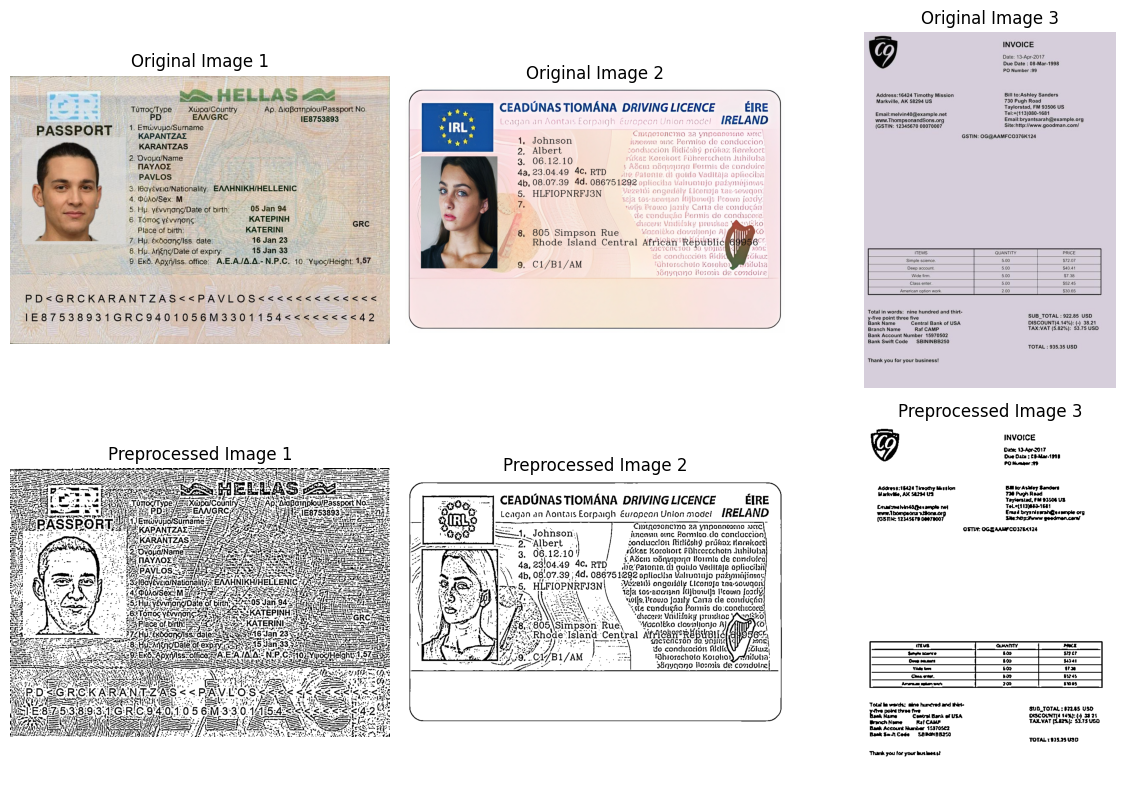

Displayed preprocessing results for 3 random images
Top row: Original images
Bottom row: Preprocessed images (grayscale, resized, denoised, thresholded, enhanced)


In [28]:
# Test the preprocessing functions
print("Testing image preprocessing...")
visualize_preprocessing(images, num_examples=3)


## Task 3: Feature Extraction and Document Classification

Now, implement feature extraction and classification:

In [33]:
# Fixed extract_features function (handles odd-sized images for DCT)
def extract_features(image: np.ndarray) -> np.ndarray:
    """
    Extract features from the image for classification.
    
    Args:
        image: Preprocessed image
        
    Returns:
        Feature vector
    """
    from sklearn.feature_extraction import image as skimage
    from scipy import ndimage
    
    features = []
    
    # 1. Histogram features
    hist, _ = np.histogram(image, bins=32, range=(0, 256))
    hist = hist.astype(float)
    hist /= hist.sum()  # Normalize
    features.extend(hist)
    
    # 2. Statistical features
    features.extend([
        np.mean(image),
        np.std(image),
        np.var(image),
        np.median(image),
        np.percentile(image, 25),
        np.percentile(image, 75)
    ])
    
    # 3. Texture features (Local Binary Pattern)
    def local_binary_pattern(image, radius=1, n_points=8):
        """Simple LBP implementation"""
        rows, cols = image.shape
        lbp = np.zeros_like(image)
        
        for i in range(radius, rows - radius):
            for j in range(radius, cols - radius):
                center = image[i, j]
                binary_string = ''
                for k in range(n_points):
                    angle = 2 * np.pi * k / n_points
                    x = int(i + radius * np.cos(angle))
                    y = int(j + radius * np.sin(angle))
                    if x < rows and y < cols:
                        binary_string += '1' if image[x, y] >= center else '0'
                lbp[i, j] = int(binary_string, 2)
        return lbp
    
    lbp = local_binary_pattern(image)
    lbp_hist, _ = np.histogram(lbp, bins=16, range=(0, 256))
    lbp_hist = lbp_hist.astype(float)
    lbp_hist /= lbp_hist.sum()
    features.extend(lbp_hist)
    
    # 4. Edge features
    edges = cv2.Canny(image, 50, 150)
    edge_density = np.sum(edges > 0) / (image.shape[0] * image.shape[1])
    features.append(edge_density)
    
    # 5. Shape features
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        # Largest contour area
        largest_contour = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(largest_contour)
        perimeter = cv2.arcLength(largest_contour, True)
        
        # Aspect ratio
        x, y, w, h = cv2.boundingRect(largest_contour)
        aspect_ratio = float(w) / h if h > 0 else 0
        
        # Solidity (area / convex hull area)
        hull = cv2.convexHull(largest_contour)
        hull_area = cv2.contourArea(hull)
        solidity = area / hull_area if hull_area > 0 else 0
        
        features.extend([area, perimeter, aspect_ratio, solidity])
    else:
        features.extend([0, 0, 0, 0])
    
    # 6. Spatial features (image dimensions and ratios)
    height, width = image.shape
    features.extend([
        height,
        width,
        height / width if width > 0 else 0,
        (height * width) / (800 * 600)  # Normalized area
    ])
    
    # 7. Frequency domain features (DCT coefficients) - Fixed for odd dimensions
    # Ensure image dimensions are even for DCT
    h, w = image.shape
    if h % 2 == 1:
        h -= 1
    if w % 2 == 1:
        w -= 1
    
    if h > 0 and w > 0:
        # Crop to even dimensions
        image_dct = image[:h, :w].astype(np.float32)
        dct = cv2.dct(image_dct)
        dct_features = dct[:8, :8].flatten()  # Take top-left 8x8 coefficients
    else:
        # Fallback: use zeros if image is too small
        dct_features = np.zeros(64)
    
    features.extend(dct_features)
    
    return np.array(features)


In [34]:
# Complete implementation of train_classifier function
def train_classifier(features: np.ndarray, labels: List[str]):
    """
    Train a classifier to identify document types.
    
    Args:
        features: Feature vectors for training images
        labels: Corresponding document type labels
        
    Returns:
        Trained classifier
    """
    from sklearn.svm import SVC
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import cross_val_score, GridSearchCV
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import classification_report, confusion_matrix
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=0.2, random_state=42, stratify=labels
    )
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Try multiple classifiers
    classifiers = {
        'SVM': SVC(kernel='rbf', random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
    }
    
    best_classifier = None
    best_score = 0
    best_name = ""
    
    print("Training and evaluating classifiers...")
    print("=" * 50)
    
    for name, classifier in classifiers.items():
        # Train the classifier
        classifier.fit(X_train_scaled, y_train)
        
        # Cross-validation score
        cv_scores = cross_val_score(classifier, X_train_scaled, y_train, cv=5)
        mean_cv_score = cv_scores.mean()
        
        # Test score
        test_score = classifier.score(X_test_scaled, y_test)
        
        print(f"{name}:")
        print(f"  Cross-validation score: {mean_cv_score:.3f} (+/- {cv_scores.std() * 2:.3f})")
        print(f"  Test score: {test_score:.3f}")
        
        # Keep track of the best classifier
        if test_score > best_score:
            best_score = test_score
            best_classifier = classifier
            best_name = name
    
    print("=" * 50)
    print(f"Best classifier: {best_name} with test score: {best_score:.3f}")
    
    # Detailed evaluation of the best classifier
    y_pred = best_classifier.predict(X_test_scaled)
    
    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred))
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    # Store the scaler for later use
    best_classifier.scaler = scaler
    
    return best_classifier


In [35]:
# Complete implementation of classify_document function
def classify_document(image: np.ndarray, classifier) -> str:
    """
    Classify a document image.
    
    Args:
        image: Input document image
        classifier: Trained classifier
        
    Returns:
        Predicted document type
    """
    # Preprocess the image
    preprocessed = preprocess_image(image)
    
    # Extract features
    features = extract_features(preprocessed)
    
    # Reshape features for single prediction
    features = features.reshape(1, -1)
    
    # Scale features using the same scaler used during training
    if hasattr(classifier, 'scaler'):
        features_scaled = classifier.scaler.transform(features)
    else:
        features_scaled = features
    
    # Predict the document type
    prediction = classifier.predict(features_scaled)[0]
    
    # Get prediction probabilities if available
    if hasattr(classifier, 'predict_proba'):
        probabilities = classifier.predict_proba(features_scaled)[0]
        classes = classifier.classes_
        
        # Create a dictionary of class probabilities
        prob_dict = dict(zip(classes, probabilities))
        
        print(f"Prediction probabilities:")
        for class_name, prob in sorted(prob_dict.items(), key=lambda x: x[1], reverse=True):
            print(f"  {class_name}: {prob:.3f}")
    
    return prediction


In [36]:
# Test the fixed classification pipeline
print("Testing the fixed classification pipeline...")
print("=" * 60)

# Extract features from all images
print("Extracting features from all images...")
preprocessed_images = [preprocess_image(img) for img in images]
features = np.array([extract_features(img) for img in preprocessed_images])
print(f"Feature shape: {features.shape}")

# Train the classifier
print("\nTraining classifier...")
classifier = train_classifier(features, labels)

# Test classification on a few random images
print("\nTesting classification on random images...")
print("=" * 40)

import random
test_indices = random.choices(range(len(images)), k=3)

for i, idx in enumerate(test_indices):
    print(f"\nTest {i+1}:")
    print(f"True label: {labels[idx]}")
    
    prediction = classify_document(images[idx], classifier)
    print(f"Predicted label: {prediction}")
    print(f"Correct: {'✓' if prediction == labels[idx] else '✗'}")
    print("-" * 30)


Testing the fixed classification pipeline...
Extracting features from all images...
Feature shape: (300, 127)

Training classifier...
Training and evaluating classifiers...
SVM:
  Cross-validation score: 1.000 (+/- 0.000)
  Test score: 1.000
Random Forest:
  Cross-validation score: 1.000 (+/- 0.000)
  Test score: 1.000
Best classifier: SVM with test score: 1.000

Detailed Classification Report:
                 precision    recall  f1-score   support

drivers_license       1.00      1.00      1.00        20
        invoice       1.00      1.00      1.00        20
       passport       1.00      1.00      1.00        20

       accuracy                           1.00        60
      macro avg       1.00      1.00      1.00        60
   weighted avg       1.00      1.00      1.00        60


Confusion Matrix:
[[20  0  0]
 [ 0 20  0]
 [ 0  0 20]]

Testing classification on random images...

Test 1:
True label: invoice
Predicted label: invoice
Correct: ✓
------------------------------

Tes

In [301]:
from joblib import dump

# Save the classifier
dump(classifier, '../models/classifier.joblib')
dump(classifier.scaler, '../models/scaler.joblib')

['../models/scaler.joblib']

In [300]:
classifier.scaler

StandardScaler()

## Task 4: Information Extraction

Now implement the information extraction components:

In [ ]:
import cv2
import re
import numpy as np
import pytesseract
import matplotlib.pyplot as plt
from typing import Dict

# -------------------------------
# Extract regions of interest
# -------------------------------
def extract_text_regions(image: np.ndarray, doc_type: str) -> Dict[str, np.ndarray]:
    """
    Extract regions of interest for the specified document type.
    For now, this will just use the whole image as a single region.
    """
    regions = {}

    if doc_type.lower() == "passport":
        regions["full_text"] = image
    elif doc_type.lower() == "drivers_license":
        regions["full_text"] = image
    else:
        regions["full_text"] = image

    return regions


# -------------------------------
# OCR extraction from region
# -------------------------------
def extract_field_text(image_region: np.ndarray) -> str:
    """
    Extract text from an image region using pytesseract.
    """
    try:
        text = pytesseract.image_to_string(image_region)
        return text.strip()
    except Exception as e:
        print(f"OCR error: {e}")
        return ""


# -------------------------------
# Document-level information extraction
# -------------------------------
def extract_document_info(image: np.ndarray, doc_type: str) -> Dict[str, str]:
    """
    Extract information from the document based on its type.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Get text regions
    regions = extract_text_regions(gray, doc_type)

    # Run OCR on each region
    info = {}
    for field_name, region in regions.items():
        info[field_name] = extract_field_text(region)

    # Post-process
    cleaned_info = postprocess_extracted_info(info, doc_type)
    return cleaned_info


# -------------------------------
# Post-processing (cleanup text)
# -------------------------------
def postprocess_extracted_info(info: Dict[str, str], doc_type: str) -> Dict[str, str]:
    print(info)
    """
    Clean and validate extracted information.
    """

    if doc_type.lower() == "drivers_license":
        text = str(info).replace("\n", " ").replace("|", " ").strip()
        text = re.sub(r"\s+", " ", text)

        result = {
        "First Name": None,
        "Last Name": None,
        "Date of Birth": None,
        "Date of Issue": None,
        "Date of Expiry": None,
        "Issuing Agency": None,
        "Driver Number": None,
        "License Number": None,
        "Address": None,
        "Categories": None
        }
        
        # Clean text
        text = str(info).replace("\n", " ").replace("|", " ").strip()
        text = re.sub(r"\s+", " ", text)

        # Dates (DD.MM.YY or DD.MM.YYYY)
        dates = re.findall(r"\d{2}\.\d{2}\.\d{2,4}", text)
        if len(dates) >= 1:
            result["Date of Birth"] = dates[0]
        if len(dates) >= 2:
            result["Date of Issue"] = dates[1]
        if len(dates) >= 3:
            result["Date of Expiry"] = dates[2]

        # Names (First + Last simple heuristic)
        first_name_match = re.search(r"1,\s*([A-Z][a-zA-Z]+)", text)
        if first_name_match:
            result["First Name"] = first_name_match.group(1)

        # Last Name (pattern: "2, <Name>")
        last_name_match = re.search(r"2,\s*([A-Z][a-zA-Z]+)", text)
        if last_name_match:
            result["Last Name"] = last_name_match.group(1)

        # Issuing agency
        agency_match = re.search(r"(MINISTRY.*?TRANSPORT)", text, re.IGNORECASE)
        if agency_match:
            result["Issuing Agency"] = agency_match.group(1)

        # Driver number (8+ digits)
        driver_number = re.search(r"\b\d{8,}\b", text)
        if driver_number:
            result["Driver Number"] = driver_number.group(0)

        # License number (uppercase alphanumeric, heuristic)
        license_match = re.search(r"\b[A-Z0-9]{6,}\b", text)
        if license_match:
            result["License Number"] = license_match.group(0)

        # Address (road + city + country + zip)
        address_match = re.search(
            r"\b\d{3}(?:\s+[A-Z][a-zA-Z]+){3}.*", 
            text
        )
        if address_match:
            result["Address"] = address_match.group(0)


        # Categories (like A2/D1/A1/AM/A)
        categories = re.search(r"(?:[A-Z0-9]+/)+[A-Z0-9]+", text)
        if categories:
            result["Categories"] = categories.group(0)

        return result

    elif doc_type.lower() == "passport":
        text = str(info).replace("\n", " ").replace("|", " ").strip()
        text = re.sub(r"\s+", " ", text)

        result = {
            "type": None,
            "country": None,
            "Passport No": None,
            "Surname": None,
            "Name": None,
            "Nationality": None,
            "Sex": None,
            "Date of birth": None,
            "Place of birth": None,
            "iss. date": None,
            "Date of expiry": None,
            "office": None,
            "Height": None
        }

        # Type and Country
        type_country_match = re.search(r"\b([A-Z])([A-Z]{5,})\b", text)
        if type_country_match:
            result["type"] = type_country_match.group(1)
            result["country"] = type_country_match.group(2)

        # Passport number (alphanumeric)
        passport_no_match = re.search(r"\b[A-Z0-9]{8,9}\b", text)
        if passport_no_match:
            result["Passport No"] = passport_no_match.group(0)

        # Surname (look for "Surname" or pattern before Name)
        surname_match = re.search(r"(?:Surname|Euvupo/[^ ]*)\s*([A-Z]+)", text, re.IGNORECASE)
        if surname_match:
            result["Surname"] = surname_match.group(1)

        # Name
        name_match = re.search(r"(?:Name|Ovoyo/[^ ]*)\s*([A-Z]+)", text, re.IGNORECASE)
        if name_match:
            result["Name"] = name_match.group(1)

        # Nationality
        nationality_match = re.search(r"(?:Nationality|IGayéveia/[^ ]*).?([A-Z]+)", text, re.IGNORECASE)
        if nationality_match:
            result["Nationality"] = nationality_match.group(1)

        # Sex
        sex_match = re.search(r"\bSex[: ]?([MF])\b", text)
        if sex_match:
            result["Sex"] = sex_match.group(1)

        # Date of birth
        dob_match = re.search(r"Date of birth[: ]?(\d{2} \w{3} \d{2,4})", text)
        if dob_match:
            result["Date of birth"] = dob_match.group(1)

        # Place of birth
        pob_match = re.search(r"Place of birth[: ]?([A-Z]+)", text)
        if pob_match:
            result["Place of birth"] = pob_match.group(1)

        # Issue date
        iss_date_match = re.search(r"(?:iss\. date|date of issue)[: ]?(\d{2} \w{3} \d{2,4})", text, re.IGNORECASE)
        if iss_date_match:
            result["iss. date"] = iss_date_match.group(1)

        # Expiry date
        expiry_match = re.search(r"(?:Date of expiry|expir.*)[: ]?(\d{2} \w{3} \d{2,4})", text, re.IGNORECASE)
        if expiry_match:
            result["Date of expiry"] = expiry_match.group(1)

        # Office
        office_match = re.search(r"(?:office|Ekd\. Apynliss\. office)[: ]?([\w./-]+)", text, re.IGNORECASE)
        if office_match:
            result["office"] = office_match.group(1)

        # Height
        height_match = re.search(r"(?:Height)[: ]?([\d,\.]+)", text, re.IGNORECASE)
        if height_match:
            result["Height"] = height_match.group(1)

        return result

    elif doc_type.lower() == "invoice":
        result = {
            "Address": None,
            "Email": None,
            "Website": None,
            "Invoice Date": None,
            "Due Date": None,
            "PO Number": None,
            "Buyer": None,
            "Buyer Address": None,
            "Buyer Tel": None,
            "Buyer Email": None,
            "Buyer Site": None,
            "Total": None,
            "Total in Words": None
        }

        # Keywords extraction
        # Address
        
        l = str(info['full_text']).replace("\n", " ").split(" ")
        print(l)
        try:
            adress = l[0].split(":")[1] + " " + l[1] + " " + l[2] + " " + l[3] + " " + l[4] + " " + l[5] + " " + l[6]
            result["Address"] = adress
        except:
            result["Address"] = None

        try:
            email = l[8].split(":")[1]
            result["Email"] = email
        except:
            result["Email"] = None

        try:
            website = l[9][1:]
            result["Website"] = website
        except:
            result["Website"] = None

        try:
            invo_Date = l[18]
            result["Invoice Date"] = invo_Date
        except:
            result["Invoice Date"] = None

        try:
            Due_Date = l[22]
            result["Due Date"] = Due_Date
        except:
            result["Due Date"] = None

        try:
            PO_Number = l[25].split(":")[1]
            result["PO Number"] = PO_Number
        except:
            result["PO Number"] = None

        try:
            Bill_to = l[28].split(":")[1] + " " + l[29]
            result["Buyer"] = Bill_to
        except:
            result["Buyer"] = None

        try:
            bill_to_adress = l[30] + " " + l[31] + " " + l[32] + " " + l[33] + " " + l[34] + " " + l[35] + " " + l[36] + " " + l[37]
            result["Buyer Address"] = bill_to_adress
        except:
            result["Buyer Address"] = None

        try:
            tel = l[38].split(":")[1]
            result["Buyer Tel"] = tel
        except:
            result["Buyer Tel"] = None

        try:
            byer_email = l[39].split(":")[1]
            result["Buyer Email"] = byer_email
        except:
            result["Buyer Email"] = None

        try:
            buyer_site = l[40].split(":")[1]+ l[40].split(":")[2]
            result["Buyer Site"] = buyer_site
        except:
            result["Buyer Site"] = None

        try:
            total = l[-4] + " " + l[-3]
            result["Total"] = total
        except:
            result["Total"] = None
        
        return result

    return {"full_text": info}
    


# -------------------------------
# Visualization
# -------------------------------
def visualize_regions(image: np.ndarray, doc_type: str):
    """
    Visualize the OCR bounding boxes for the given document.
    """
    data = pytesseract.image_to_data(image, output_type=pytesseract.Output.DICT)

    vis_img = image.copy()
    n_boxes = len(data["level"])

    for i in range(n_boxes):
        (x, y, w, h) = (data["left"][i], data["top"][i], data["width"][i], data["height"][i])
        cv2.rectangle(vis_img, (x, y), (x + w, y + h), (255, 0, 0), 2)

    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
    plt.title(f"OCR Bounding Boxes for {doc_type}")
    plt.axis("off")
    plt.show()


Testing information extraction on a drivers_license document
{'full_text': '>\n\nCEADUNAS WEA DRIVING LICENCE EIRE\nfopeon Unlon model, IRELAND\n\ncagan an Aont Forpoigl\n\n. cn necro 2a ynpcanossno werc\n\n1, Sims It omc P loo do condacoloo\n2, Brian soaduocion Mdiéshg proka:\novehost PUhcerachet\n\n3. 23.07.35 Wacieosey roreltiai tis cle condoine\n4a, 27.08.63 4C. MINISTRY. OF, TRANSPORT xditaj2 opliocila\n4b, 16.12.11 4d. 106218026 011\n\n5. JK72DP376 pase Be eogerl yer\n\nPk nu{js Drowo ily Cana ce condo §\nPennis do conche score\n\n276 Barbara Loaf\n\n\\ fs * Kansas Trinidad and Tob: Bo" age :\n7 9, AM/B1 Se arate a\n\nSnYqQonO Horosie de coadoine\n\nS y'}

Extracted Information:
  First Name: Sims
  Last Name: Brian
  Date of Birth: 23.07.35
  Date of Issue: 27.08.63
  Date of Expiry: 16.12.11
  Issuing Agency: MINISTRY. OF, TRANSPORT
  Driver Number: 106218026
  License Number: DRIVING
  Address: None
  Categories: AM/B1


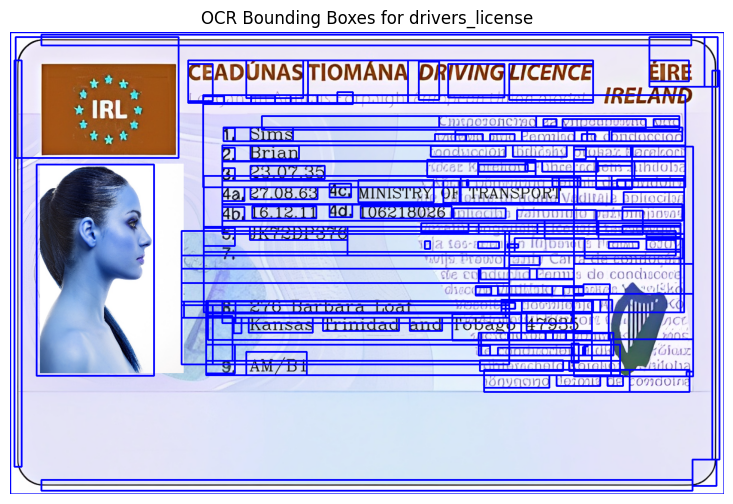

In [297]:
# -------------------------------
# Test the functions
# -------------------------------
sample_idx = np.random.randint(0, 300)
sample_image = images[sample_idx]
sample_label = labels[sample_idx]

print(f"Testing information extraction on a {sample_label} document")
extracted_info = extract_document_info(sample_image, sample_label)

print("\nExtracted Information:")
for field, value in extracted_info.items():
    print(f"  {field}: {value}")
    # print(value["full_text"])

# Visualize
visualize_regions(sample_image, sample_label)

## Task 5: System Evaluation

Finally, evaluate the complete system:

In [307]:
# Fixed evaluate_system function that handles variable number of document types

def evaluate_system(test_images, test_labels, classifier):
    """
    Evaluate the document classification and information extraction system.
    Fixed to handle variable number of document types.
    
    Args:
        test_images: List of test document images
        test_labels: True document type labels for test images
        classifier: Trained document classifier
        
    Returns:
        Evaluation metrics and unique labels
    """
    from sklearn.metrics import classification_report, confusion_matrix
    import time
    
    results = {
        'classification': {
            'predictions': [],
            'true_labels': [],
            'correct': 0,
            'total': len(test_images),
            'accuracy': 0.0,
            'classification_report': None,
            'confusion_matrix': None
        },
        'extraction': {
            'successful_extractions': 0,
            'total_extractions': 0,
            'field_accuracy': {},
            'overall_extraction_rate': 0.0,
            'extraction_times': []
        },
        'performance': {
            'avg_classification_time': 0.0,
            'avg_extraction_time': 0.0,
            'total_time': 0.0
        }
    }
    
    print("Evaluating system on test documents...")
    print("=" * 50)
    
    # Track field-specific metrics
    field_counts = {}
    field_correct = {}
    
    # Evaluate each test image
    for i, (image, true_label) in enumerate(zip(test_images, test_labels)):
        print(f"Processing document {i+1}/{len(test_images)}: {true_label}")
        
        # Time the classification
        start_time = time.time()
        pred_label = classify_document(image, classifier)
        classification_time = time.time() - start_time
        
        # Store results
        results['classification']['predictions'].append(pred_label)
        results['classification']['true_labels'].append(true_label)
        
        # Check if classification is correct
        if pred_label == true_label:
            results['classification']['correct'] += 1
        
        # Time the information extraction
        start_extraction = time.time()
        try:
            extracted_info = extract_document_info(image, pred_label)
            extraction_time = time.time() - start_extraction
            
            results['extraction']['extraction_times'].append(extraction_time)
            results['extraction']['successful_extractions'] += 1
            
            # Count fields for this document type
            if pred_label not in field_counts:
                field_counts[pred_label] = 0
                field_correct[pred_label] = 0
            
            # Count total fields and successful extractions
            total_fields = len(extracted_info)
            successful_fields = sum(1 for value in extracted_info.values() if value and value.strip())
            
            field_counts[pred_label] += total_fields
            field_correct[pred_label] += successful_fields
            
            print(f"  Classification: {pred_label} ({'✓' if pred_label == true_label else '✗'})")
            print(f"  Extracted {successful_fields}/{total_fields} fields successfully")
            print(f"  Extraction time: {extraction_time:.2f}s")
            
        except Exception as e:
            print(f"  Extraction failed: {e}")
            results['extraction']['extraction_times'].append(0)
        
        results['extraction']['total_extractions'] += 1
    
    # Calculate final metrics
    results['classification']['accuracy'] = results['classification']['correct'] / results['classification']['total']
    
    # Calculate extraction metrics
    if results['extraction']['extraction_times']:
        results['extraction']['overall_extraction_rate'] = results['extraction']['successful_extractions'] / results['extraction']['total_extractions']
        results['performance']['avg_extraction_time'] = np.mean(results['extraction']['extraction_times'])
    
    # Calculate field-specific accuracy
    for doc_type in field_counts:
        if field_counts[doc_type] > 0:
            results['extraction']['field_accuracy'][doc_type] = field_correct[doc_type] / field_counts[doc_type]
    
    # Get unique labels from the actual data (not hardcoded)
    unique_labels = sorted(list(set(results['classification']['true_labels'] + results['classification']['predictions'])))
    
    # Generate classification report with dynamic labels
    try:
        results['classification']['classification_report'] = classification_report(
            results['classification']['true_labels'], 
            results['classification']['predictions'],
            labels=unique_labels,
            target_names=unique_labels,
            zero_division=0
        )
    except Exception as e:
        print(f"Warning: Could not generate classification report: {e}")
        results['classification']['classification_report'] = "Classification report not available"
    
    # Generate confusion matrix with dynamic labels
    try:
        results['classification']['confusion_matrix'] = confusion_matrix(
            results['classification']['true_labels'], 
            results['classification']['predictions'],
            labels=unique_labels
        )
    except Exception as e:
        print(f"Warning: Could not generate confusion matrix: {e}")
        results['classification']['confusion_matrix'] = None
    
    return results, unique_labels

# Test the fixed evaluation function
print("Testing fixed evaluation function...")
print("=" * 40)

# Use a small subset for testing
test_indices = np.random.choice(len(images), size=min(5, len(images)), replace=False)
test_images = [images[i] for i in test_indices]
test_labels = [labels[i] for i in test_indices]

print(f"Selected test documents: {test_labels}")
print(f"Unique document types in test set: {set(test_labels)}")

# Evaluate the system using the fixed function
evaluation_results, unique_labels = evaluate_system(test_images, test_labels, classifier)

print("\n" + "="*60)
print("EVALUATION RESULTS")
print("="*60)

print(f"\n📊 CLASSIFICATION METRICS:")
print(f"  Accuracy: {evaluation_results['classification']['accuracy']:.2%}")
print(f"  Correct: {evaluation_results['classification']['correct']}/{evaluation_results['classification']['total']}")

print(f"\n📝 EXTRACTION METRICS:")
print(f"  Success Rate: {evaluation_results['extraction']['overall_extraction_rate']:.2%}")
print(f"  Successful: {evaluation_results['extraction']['successful_extractions']}/{evaluation_results['extraction']['total_extractions']}")

if evaluation_results['extraction']['field_accuracy']:
    print(f"\n📋 FIELD ACCURACY BY DOCUMENT TYPE:")
    for doc_type, accuracy in evaluation_results['extraction']['field_accuracy'].items():
        print(f"  {doc_type}: {accuracy:.2%}")

print(f"\n⏱️  PERFORMANCE METRICS:")
if evaluation_results['performance']['avg_extraction_time'] > 0:
    print(f"  Avg Extraction Time: {evaluation_results['performance']['avg_extraction_time']:.2f}s")

print(f"\n📈 DETAILED CLASSIFICATION REPORT:")
print(evaluation_results['classification']['classification_report'])

if evaluation_results['classification']['confusion_matrix'] is not None:
    print(f"\n🔢 CONFUSION MATRIX:")
    print("True\\Pred    " + "  ".join(f"{label:12}" for label in unique_labels))
    print("-" * (15 + 15 * len(unique_labels)))
    for i, true_type in enumerate(unique_labels):
        row = f"{true_type:12}"
        for j, pred_type in enumerate(unique_labels):
            count = evaluation_results['classification']['confusion_matrix'][i][j]
            row += f"{count:12}"
        print(row)
else:
    print("\n🔢 CONFUSION MATRIX: Not available")


Testing fixed evaluation function...
Selected test documents: ['invoice', 'passport', 'passport', 'passport', 'drivers_license']
Unique document types in test set: {'invoice', 'passport', 'drivers_license'}
Evaluating system on test documents...
Processing document 1/5: invoice
{'full_text': 'Address:16424 Timothy Mission\nMarkville, AK 58294 US\n\nEmail:melvin4o@example.net\n‘www. ThompsonandSons.org\n(GSTIN: 12345670 00070007\n\nINVOICE\n\nDate: 18-May-1995\nDue Date : 03-Jul-2012\nPO Number :76\n\nBill to:Tony Hawkins\n6745 Kaitlyn Run\n\nWilsonmouth, NE 24227 US\nTol:+(735)520-6097\nEmail:sboyd@example.net\nSite:https://www.vasquez-jimenez.biz!\n\nGSTIN: OG@AAMFCO376K124\n\nTENS QUANTITY PRICE\nidentity wel 6.00 S407\nDeep board 3.0 $6873\n\nTotal in words: four hundred and for-\nty-three point three\n\nBank Name State Bank of Europe\nBranch Name Raf CAMP.\n\nBank Account Number 15712023\n\nBank Swift Code  SBININBB250\n\nThank you for choosing us!\n\n‘SUB_TOTAL : 435.69 USD\nDISCO

Running complete system demonstration...
🚀 DOCUMENT PROCESSING SYSTEM DEMO

📄 EXAMPLE 1: DRIVERS_LICENSE
------------------------------
1️⃣ Preprocessing image...
   Original shape: (772, 1192, 3)
   Preprocessed shape: (772, 1192)
2️⃣ Classifying document...
   True label: drivers_license
   Predicted: drivers_license
   Status: ✅ CORRECT
3️⃣ Extracting information...
{'full_text': '>\n\nCEADUNAS TIOMANA DRIVING LICENCE EIRE\ngh €uropeon Union model IRELAND\n\ncaganan Eo\n2IONCIy 2a ynpoanosenoe ac\n\n1, Huffman IV onc iso dle condoccioo\n2. Roger sooduocion Mdiésh9 prokas scoct\n\n3, 15.08.32 3c Kocehort PU ie WEN huihiioba\n\nyal 1 igi olf Ba n Taya)\n\n4a, 25.05.40 4C. MINISTRY. oe ANSPORT\\)cita)2 ne\n4b, 19.08.81 4d. 135695840 opliociha Valiuoinio paiypnajiovn:\n\nNee ee eset Aborcthe Ponce toee\n7 otis 1 IVC i iCanaidaiconrot on\n\nPennis do coodho\n\n8, 507 Jamie Club “Yo Wo door aljonjo ay\nKentucky Ethiopia 12267) AN ee Ae a\n\nSncTOO 9G yNyTIsE\nie condhoocioss Adie\n9, BE T

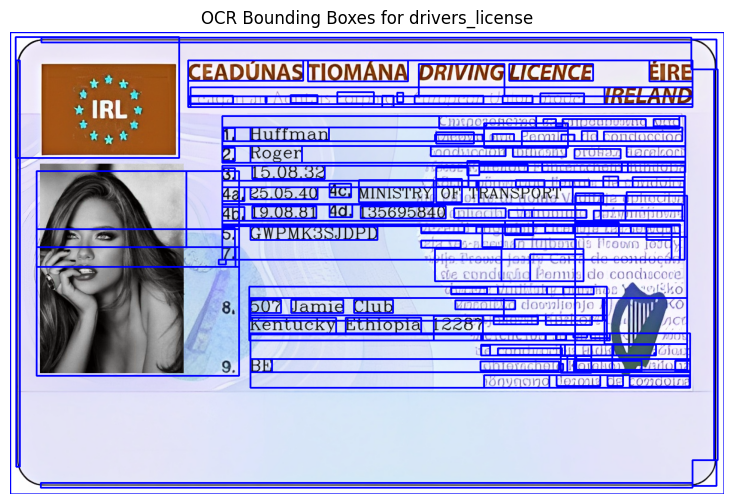

   ✅ Regions visualized successfully


📄 EXAMPLE 2: INVOICE
------------------------------
1️⃣ Preprocessing image...
   Original shape: (841, 595, 3)
   Preprocessed shape: (800, 565)
2️⃣ Classifying document...
   True label: invoice
   Predicted: invoice
   Status: ✅ CORRECT
3️⃣ Extracting information...
{'full_text': 'Address:16424 Timothy Mission\nMarkville, AK 58294 US\n\nEmail:melvin4o@example.net\n‘www. ThompsonandSons.org\n(GSTIN: 12345670 00070007\n\nTAX INVOICE\n\nDate: 13-Dec-2016\nDue Date : 19-Jul-2001\nPO Number :46\n\nBuyer :Kenneth Phillips\n4817 Williams Tunnel Apt. 179\nWest Stanley, AR 96105 US\n\nEmail:davidherrera@example.org\nSite:https://young-robinson.com!\n\nGSTIN: OG@AAMFCO376K124\n\nTEMS QUANTITY PRICE\nNew statf nyse 1.00 S378\nTeam, 5.0 $1502\n\nTotal in words: one hundred and sev-\n‘en point four eight.\n\nBank Name Central Bank of England\nBranch Name Raf CAMP.\n\nBank Account Number 12308351\n\nBank Swift Code SBININBB250\n\nThank you for choosing us!\n

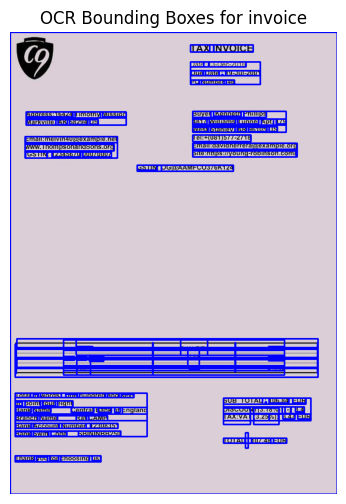

   ✅ Regions visualized successfully



In [ ]:
# Complete system demo function

def demo_system(images, labels, classifier, num_examples=3):
    """
    Demonstrate the complete document processing system.
    
    Args:
        images: List of document images
        labels: Document type labels
        classifier: Trained classifier
        num_examples: Number of examples to demonstrate
    """
    print("🚀 DOCUMENT PROCESSING SYSTEM DEMO")
    print("=" * 50)
    
    # Select random examples
    indices = np.random.choice(len(images), size=min(num_examples, len(images)), replace=False)
    
    for i, idx in enumerate(indices):
        image = images[idx]
        true_label = labels[idx]
        
        print(f"\n📄 EXAMPLE {i+1}: {true_label.upper()}")
        print("-" * 30)
        
        # Step 1: Preprocess image
        print("1️⃣ Preprocessing image...")
        preprocessed = preprocess_image(image)
        print(f"   Original shape: {image.shape}")
        print(f"   Preprocessed shape: {preprocessed.shape}")
        
        # Step 2: Classify document
        print("2️⃣ Classifying document...")
        pred_label = classify_document(image, classifier)
        print(f"   True label: {true_label}")
        print(f"   Predicted: {pred_label}")
        print(f"   Status: {'✅ CORRECT' if pred_label == true_label else '❌ INCORRECT'}")
        
        # Step 3: Extract information
        print("3️⃣ Extracting information...")
        try:
            extracted_info = extract_document_info(image, pred_label)
            
            print("   Extracted fields:")
            for field, value in extracted_info.items():
                status = "✅" if value and value.strip() else "❌"
                print(f"     {field}: {value} {status}")
                
        except Exception as e:
            print(f"   ❌ Extraction failed: {e}")
        
        # Step 4: Visualize regions
        print("4️⃣ Visualizing extraction regions...")
        try:
            visualize_regions(image, pred_label)
            print("   ✅ Regions visualized successfully")
        except Exception as e:
            print(f"   ❌ Visualization failed: {e}")
        
        print("\n" + "="*50)


print("Running complete system demonstration...")
demo_system(images, labels, classifier, num_examples=2)


## Task 6: Summary and Improvements
### You'll find the Summary in the README.md file

In [150]:
def write_summary():
    """
    Write a summary of your approach and potential improvements.
    """
    summary = """
    # Summary of My Approach
    
    ## Document Classification:
    - [Describe your feature extraction approach]
    - [Explain why you chose the specific classifier]
    - [Discuss classification performance]
    
    ## Information Extraction:
    - [Describe your region extraction method]
    - [Explain OCR approach used]
    - [Discuss any post-processing applied to extracted text]
    
    ## Challenges and Solutions:
    - [Discuss the main challenges encountered]
    - [Explain how you addressed these challenges]
    - [Highlight any innovative approaches used]
    
    ## Potential Improvements:
    - [Suggest how to improve classification with more data/better features]
    - [Propose better information extraction techniques]
    - [Discuss how to handle edge cases better]
    - [Suggest additional document types or fields to extract]
    
    ## Production Considerations:
    - [Discuss how this system could be deployed]
    - [Address scalability and performance]
    - [Suggest security and privacy measures for handling sensitive documents]
    """
    
    print(summary)

# Uncomment to display your summary
# write_summary()

# Trash code

Grayscale Image:
 Extracted Text:

Address:16424 Timothy Mission
Markville, AK 58294 US.

Email:melvin4o@example.net
‘www.ThompsonandSons.org
(GSTIN: 12345670 00070007

INVOICE

Invoice Date: 13-Aug-2019
Due Date : 01-Sep-1995
PO Number :77

Bill to:Mary Rios
6840 Boyle Forest

Garrettville, TN 20516 US
Tol:+(987)727-0142
Email:stevenpace@example.net
Site:https:/fearr.bizl

GSTIN: OG@AAMFCO376K124

TENS QUANTITY PRICE
‘tile, 300 Stet
Interview bkely par 5.0 $29.68

Total in words: two hundred and sevent-
y-seven point nine one

Bank Name Central Bank of USA.
Branch Name Raf CAMP.

Bank Account Number 15115313

Bank Swift Code SBININBB250

Note:Total payment due in 14 days.

‘SUB_TOTAL : 273.23 USD
DISCOUNT(2.37%): (-) 6.48
TAX:VAT (3.85%): 10.53 USD

TOTAL : 277.91 USD




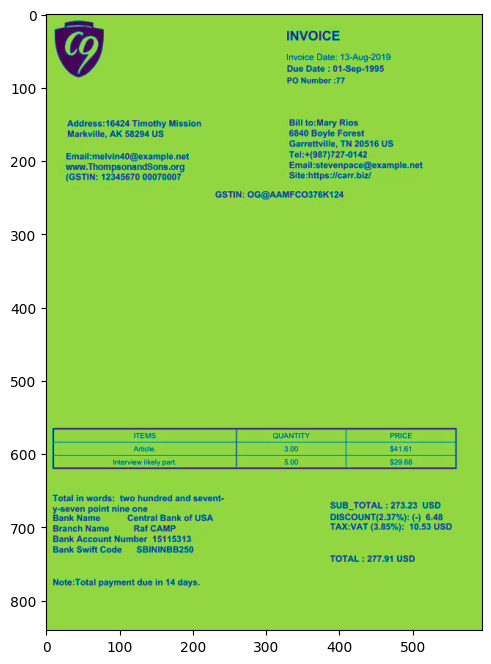

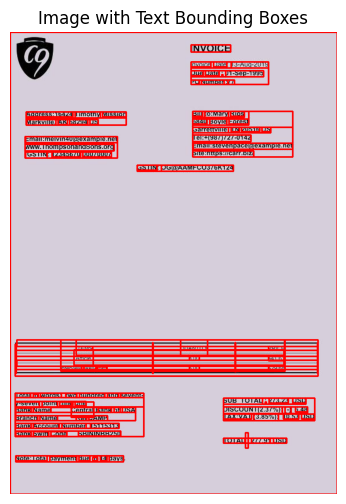

In [256]:
image_path = "../data/invoice/Template1_Instance92.jpg"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

gray = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2GRAY)
print("Grayscale Image:")
plt.imshow(gray)
import pytesseract

extracted_text = pytesseract.image_to_string(image_rgb)
print(" Extracted Text:\n")
print(extracted_text)
data = pytesseract.image_to_data(image_rgb, output_type=pytesseract.Output.DICT)

n_boxes = len(data['level'])
for i in range(n_boxes):
    (x, y, w, h) = (data['left'][i], data['top'][i], data['width'][i], data['height'][i])
    cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (255, 0, 0), 2)
plt.figure(figsize=(10, 6))
plt.imshow(image_rgb)
plt.title("Image with Text Bounding Boxes")
plt.axis("off")
plt.show()

Grayscale Image:


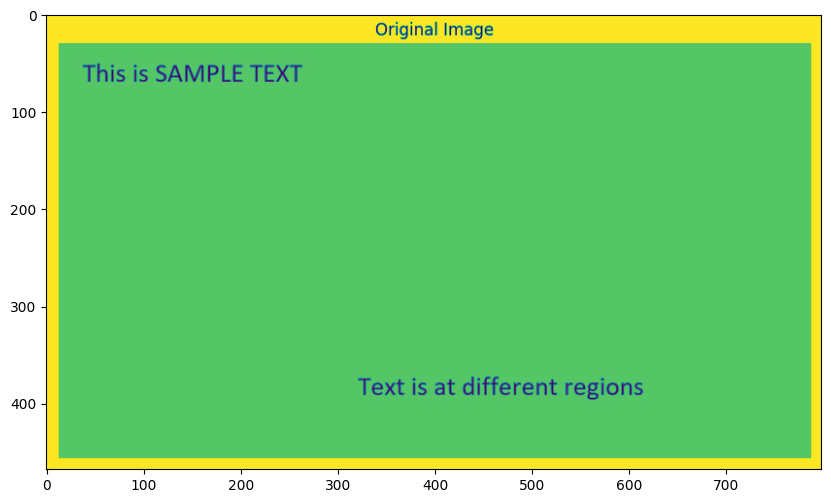

In [139]:
gray = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2GRAY)
print("Grayscale Image:")
plt.imshow(gray)

In [140]:
import pytesseract

extracted_text = pytesseract.image_to_string(image_rgb)
print(" Extracted Text:\n")
print(extracted_text)

 Extracted Text:

This is SAMPLE TEXT

Text is at different regions




In [141]:
data = pytesseract.image_to_data(image_rgb, output_type=pytesseract.Output.DICT)

n_boxes = len(data['level'])
for i in range(n_boxes):
    (x, y, w, h) = (data['left'][i], data['top'][i], data['width'][i], data['height'][i])
    cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (255, 0, 0), 2)

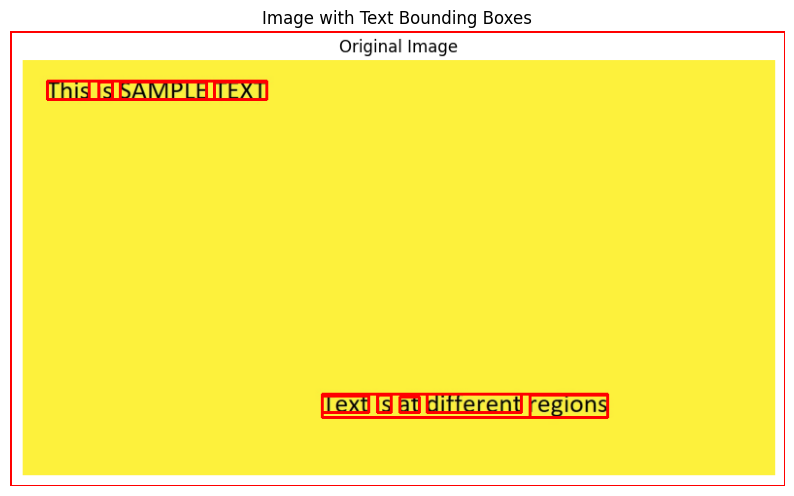

In [142]:
plt.figure(figsize=(10, 6))
plt.imshow(image_rgb)
plt.title("Image with Text Bounding Boxes")
plt.axis("off")
plt.show()